# Homework 1

## Instructions

First, ensure you have cloned the [course repository](https://github.com/lydiaYchen/DDL24Spring).

Then, open the [interactive notebook version](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/hw-hfl.ipynb) of this homework from your local clone.

Further, complete the homework by filling in the code and answers and save your changes.

Finally, upload the notebook to the assignment in ILIAS.

## Note

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction`(C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [1]:
import pandas as pd
import seaborn as sns
from base import *
from IPython.display import display
import matplotlib.pyplot as plt
import torch

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

cpu


## Exercise 1 - FedSGD with weights (3 points)

### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of at most 0.02%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

_(1 point)_ Explain in which cases (about the different parameters for decentralized learning) the two are equivalent.

### Answer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

cpu
False


Implement Infinite Batch version from FedAvgServer

In [14]:
class FedAvgServer_InfBatch(FedAvgServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list[Subset], client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.batch_size = -1
        self.clients = [WeightClient(subset, lr, len(subset), nr_local_epochs) for subset in client_subsets]

In [24]:
# define ablation function with initial values
def Ablation_Experiment(lr = 0.01, client_subsets = split(100, True, seed = 10), client_fraction = 0.1, nr_rounds = 10, avg_batchsize = 100, nr_local_epochs = 1, FedSgd_flag = True, FedAvg_flag = True, FedAvgInfBatch_flag = True):

    pd_idf = []

    if FedSgd_flag:
        fedsgd_server = FedSgdGradientServer(lr, client_subsets, client_fraction, seed)
        fedsgd_results = fedsgd_server.run(nr_rounds)
        fedsgd_df = fedsgd_results.as_df()
        display(fedsgd_df)
        pd_idf.append(fedsgd_df)
    if FedAvg_flag:
        fedavg_server = FedAvgServer(lr, avg_batchsize, client_subsets, client_fraction, nr_local_epochs, seed)
        fedavg_results = fedavg_server.run(nr_rounds)    
        fedavg_df = fedavg_results.as_df()
        display(fedavg_df)
        pd_idf.append(fedavg_df)
    if FedAvgInfBatch_flag:
        fedavginf_server = FedAvgServer_InfBatch(lr, avg_batchsize, client_subsets, client_fraction, nr_local_epochs, seed)
        fedavginf_results = fedavginf_server.run(nr_rounds)    
        fedavginf_df = fedavginf_results.as_df()
        display(fedavginf_df)
        pd_idf.append(fedavginf_df)

    plt.figure(figsize=(5, 3))
    df = pd.concat(pd_idf, ignore_index=True)
    ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=0)
    _ = ax.set_xticks(df["Round"].unique())
    plt.show()

- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5 over 5 round`

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.5,∞,1,0.01,10,0.5,100,8.84
1,2,FedSGDGradient,100,0.5,∞,1,0.01,10,1.1,200,13.48
2,3,FedSGDGradient,100,0.5,∞,1,0.01,10,3.2,300,18.55
3,4,FedSGDGradient,100,0.5,∞,1,0.01,10,5.6,400,23.08
4,5,FedSGDGradient,100,0.5,∞,1,0.01,10,6.3,500,27.53


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.5,∞,1,0.01,10,0.6,100,8.72
1,2,FedAvg,100,0.5,∞,1,0.01,10,1.3,200,13.02
2,3,FedAvg,100,0.5,∞,1,0.01,10,2.0,300,18.31
3,4,FedAvg,100,0.5,∞,1,0.01,10,2.7,400,22.88
4,5,FedAvg,100,0.5,∞,1,0.01,10,3.4,500,27.46


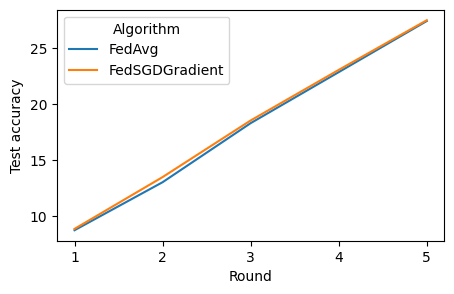

In [19]:
Ablation_Experiment(lr = 0.01, client_subsets = split(100, True, seed), client_fraction = 0.5, nr_rounds = 5)

- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,50,0.2,∞,1,0.1,10,0.9,20,16.18
1,2,FedSGDGradient,50,0.2,∞,1,0.1,10,1.7,40,24.69
2,3,FedSGDGradient,50,0.2,∞,1,0.1,10,2.8,60,13.26
3,4,FedSGDGradient,50,0.2,∞,1,0.1,10,4.0,80,22.49
4,5,FedSGDGradient,50,0.2,∞,1,0.1,10,5.1,100,37.34


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,50,0.2,∞,1,0.1,10,1.1,20,16.06
1,2,FedAvg,50,0.2,∞,1,0.1,10,2.2,40,22.98
2,3,FedAvg,50,0.2,∞,1,0.1,10,3.4,60,13.69
3,4,FedAvg,50,0.2,∞,1,0.1,10,4.6,80,20.71
4,5,FedAvg,50,0.2,∞,1,0.1,10,6.0,100,33.02


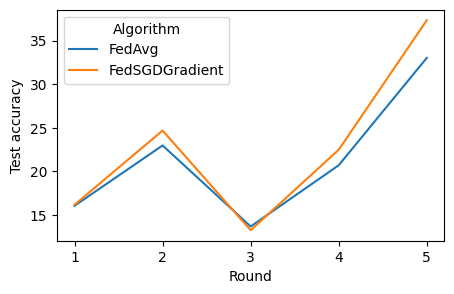

In [20]:
Ablation_Experiment(lr = 0.1, client_subsets = split(50, False, seed), client_fraction = 0.2, nr_rounds = 5)

TODO

Explain in which cases (about the different parameters for decentralized learning) the two are equivalent.

当使用FedAvg时，如果将batchsize设置为subset的长度，那么只会进行一次前向传播，因为subset的所有数据都被这次传播计算了；同时，设置epoch为1保证了client上只会进行一轮计算。也就是说当batchsize = len(subset), epoch = 1时，每个Client上的weight只会更新一次，并被上交到Server，而Server对weights加权求和再返回client，这就跟FedSGD一样。

## Exercise 2 - Client number & fraction (4 points)

### Question

_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- | ------------- | ------------- |
| FedSGD    | 10  | 0.1 |              10 |              27.15 |
| FedAvg    | 10  | 0.1 |              10 |              91.64 |
| FedSGD    | 50  | 0.1 |              50 |              26.93 |
| FedAvg    | 50  | 0.1 |              50 |              80.49 |
| FedSGD    | 100 | 0.1 |              100 |              27.34 |
| FedAvg    | 100 | 0.1 |              100 |              69.05 |

Is the relationship between the metrics and client numbers monotonous?

_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- | ------------- | ------------- |
| FedSGD    | 100 | 0.01 |              10 |              27.74 |
| FedAvg    | 100 | 0.01 |              10 |              63.72 |
| FedSGD    | 100 | 0.1  |              100 |              27.34 |
| FedAvg    | 100 | 0.1  |              100 |              69.05 |
| FedSGD    | 100 | 0.2  |              200 |              27.44 |
| FedAvg    | 100 | 0.2  |              200 |              66.25 |

How does the observed pattern differ?

### Answer

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,10,0.1,∞,1,0.1,10,15.1,2,42.07
1,2,FedSGDGradient,10,0.1,∞,1,0.1,10,29.8,4,49.81
2,3,FedSGDGradient,10,0.1,∞,1,0.1,10,44.6,6,60.03
3,4,FedSGDGradient,10,0.1,∞,1,0.1,10,64.9,8,69.54
4,5,FedSGDGradient,10,0.1,∞,1,0.1,10,79.9,10,70.67
5,6,FedSGDGradient,10,0.1,∞,1,0.1,10,96.3,12,54.95
6,7,FedSGDGradient,10,0.1,∞,1,0.1,10,112.5,14,33.22
7,8,FedSGDGradient,10,0.1,∞,1,0.1,10,117.8,16,23.19
8,9,FedSGDGradient,10,0.1,∞,1,0.1,10,131.4,18,50.81
9,10,FedSGDGradient,10,0.1,∞,1,0.1,10,146.8,20,65.58


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,10,0.1,100,1,0.1,10,10.6,2,85.40
1,2,FedAvg,10,0.1,100,1,0.1,10,17.1,4,94.46
2,3,FedAvg,10,0.1,100,1,0.1,10,21.4,6,95.92
3,4,FedAvg,10,0.1,100,1,0.1,10,25.5,8,96.15
4,5,FedAvg,10,0.1,100,1,0.1,10,29.8,10,96.36
5,6,FedAvg,10,0.1,100,1,0.1,10,33.5,12,97.19
6,7,FedAvg,10,0.1,100,1,0.1,10,37.6,14,97.20
7,8,FedAvg,10,0.1,100,1,0.1,10,41.3,16,97.65
8,9,FedAvg,10,0.1,100,1,0.1,10,44.9,18,97.73
9,10,FedAvg,10,0.1,100,1,0.1,10,48.6,20,97.85


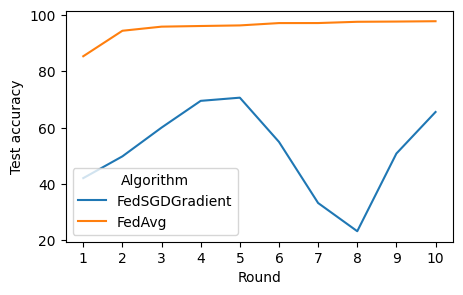

In [26]:
Ablation_Experiment(lr = 0.1, client_subsets = split(10, iid, seed), FedAvgInfBatch_flag = False)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,50,0.1,∞,1,0.1,10,1.1,10,43.12
1,2,FedSGDGradient,50,0.1,∞,1,0.1,10,2.2,20,49.47
2,3,FedSGDGradient,50,0.1,∞,1,0.1,10,5.5,30,64.58
3,4,FedSGDGradient,50,0.1,∞,1,0.1,10,8.8,40,66.58
4,5,FedSGDGradient,50,0.1,∞,1,0.1,10,11.8,50,67.94
5,6,FedSGDGradient,50,0.1,∞,1,0.1,10,14.7,60,49.78
6,7,FedSGDGradient,50,0.1,∞,1,0.1,10,17.9,70,25.51
7,8,FedSGDGradient,50,0.1,∞,1,0.1,10,20.6,80,43.69
8,9,FedSGDGradient,50,0.1,∞,1,0.1,10,21.7,90,65.22
9,10,FedSGDGradient,50,0.1,∞,1,0.1,10,22.7,100,71.76


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,50,0.1,100,1,0.1,10,1.1,10,60.98
1,2,FedAvg,50,0.1,100,1,0.1,10,3.3,20,77.27
2,3,FedAvg,50,0.1,100,1,0.1,10,5.5,30,87.37
3,4,FedAvg,50,0.1,100,1,0.1,10,10.2,40,90.31
4,5,FedAvg,50,0.1,100,1,0.1,10,12.5,50,91.11
5,6,FedAvg,50,0.1,100,1,0.1,10,15.2,60,92.13
6,7,FedAvg,50,0.1,100,1,0.1,10,17.7,70,93.70
7,8,FedAvg,50,0.1,100,1,0.1,10,19.8,80,93.63
8,9,FedAvg,50,0.1,100,1,0.1,10,21.9,90,94.19
9,10,FedAvg,50,0.1,100,1,0.1,10,24.2,100,95.00


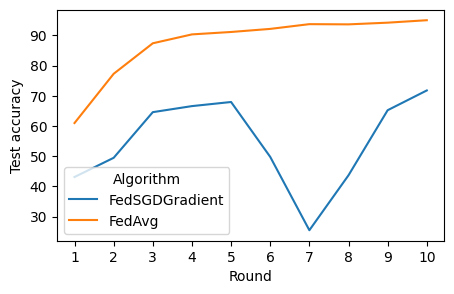

In [25]:
Ablation_Experiment(lr = 0.1, client_subsets = split(50, iid, seed), FedAvgInfBatch_flag = False)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.1,10,0.5,20,42.78
1,2,FedSGDGradient,100,0.1,∞,1,0.1,10,2.2,40,49.07
2,3,FedSGDGradient,100,0.1,∞,1,0.1,10,4.1,60,61.55
3,4,FedSGDGradient,100,0.1,∞,1,0.1,10,5.5,80,58.46
4,5,FedSGDGradient,100,0.1,∞,1,0.1,10,6.1,100,62.12
5,6,FedSGDGradient,100,0.1,∞,1,0.1,10,7.3,120,37.53
6,7,FedSGDGradient,100,0.1,∞,1,0.1,10,8.7,140,30.65
7,8,FedSGDGradient,100,0.1,∞,1,0.1,10,10.0,160,42.74
8,9,FedSGDGradient,100,0.1,∞,1,0.1,10,11.3,180,66.22
9,10,FedSGDGradient,100,0.1,∞,1,0.1,10,12.7,200,70.84


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,0.1,10,1.2,20,64.43
1,2,FedAvg,100,0.1,100,1,0.1,10,2.4,40,62.66
2,3,FedAvg,100,0.1,100,1,0.1,10,3.6,60,78.82
3,4,FedAvg,100,0.1,100,1,0.1,10,4.8,80,82.95
4,5,FedAvg,100,0.1,100,1,0.1,10,6.0,100,85.05
5,6,FedAvg,100,0.1,100,1,0.1,10,7.2,120,81.65
6,7,FedAvg,100,0.1,100,1,0.1,10,8.4,140,89.69
7,8,FedAvg,100,0.1,100,1,0.1,10,8.9,160,90.16
8,9,FedAvg,100,0.1,100,1,0.1,10,10.0,180,89.69
9,10,FedAvg,100,0.1,100,1,0.1,10,11.2,200,91.56


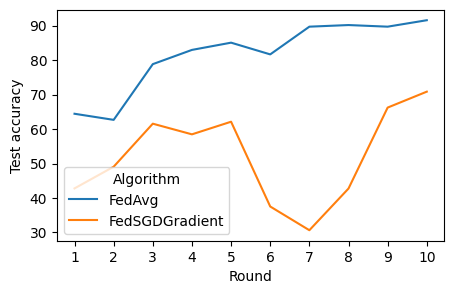

In [23]:
Ablation_Experiment(lr = 0.1, client_subsets = split(100, iid, seed), FedAvgInfBatch_flag = False)

TODO

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.01,∞,1,0.01,10,0.2,2,9.95
1,2,FedSGDGradient,100,0.01,∞,1,0.01,10,0.3,4,15.68
2,3,FedSGDGradient,100,0.01,∞,1,0.01,10,0.3,6,20.83
3,4,FedSGDGradient,100,0.01,∞,1,0.01,10,0.4,8,24.61
4,5,FedSGDGradient,100,0.01,∞,1,0.01,10,0.4,10,28.19
5,6,FedSGDGradient,100,0.01,∞,1,0.01,10,0.5,12,32.58
6,7,FedSGDGradient,100,0.01,∞,1,0.01,10,0.6,14,35.44
7,8,FedSGDGradient,100,0.01,∞,1,0.01,10,0.7,16,39.22
8,9,FedSGDGradient,100,0.01,∞,1,0.01,10,0.7,18,41.59
9,10,FedSGDGradient,100,0.01,∞,1,0.01,10,0.8,20,41.54


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.01,200,2,0.01,10,0.1,2,29.85
1,2,FedAvg,100,0.01,200,2,0.01,10,0.2,4,39.86
2,3,FedAvg,100,0.01,200,2,0.01,10,0.3,6,46.81
3,4,FedAvg,100,0.01,200,2,0.01,10,0.4,8,58.01
4,5,FedAvg,100,0.01,200,2,0.01,10,0.5,10,64.84
5,6,FedAvg,100,0.01,200,2,0.01,10,0.6,12,69.28
6,7,FedAvg,100,0.01,200,2,0.01,10,0.6,14,65.73
7,8,FedAvg,100,0.01,200,2,0.01,10,0.7,16,73.02
8,9,FedAvg,100,0.01,200,2,0.01,10,0.8,18,77.43
9,10,FedAvg,100,0.01,200,2,0.01,10,0.9,20,76.85


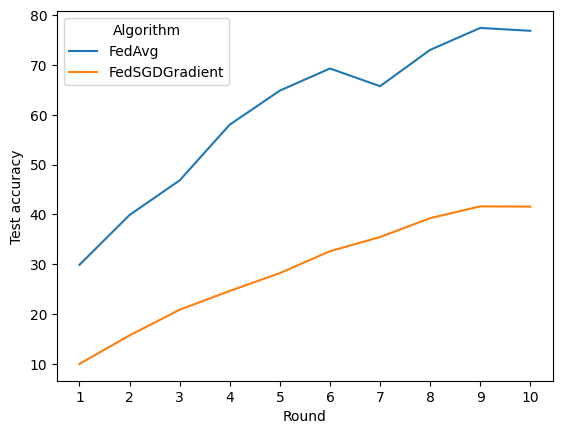

In [ ]:
client_fraction = 0.01
client_subsets_iid = split(100, True, seed)
Question(lr, client_subsets_iid, client_fraction, nr_rounds)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.2,∞,1,0.01,10,0.3,40,9.01
1,2,FedSGDGradient,100,0.2,∞,1,0.01,10,0.3,80,13.72
2,3,FedSGDGradient,100,0.2,∞,1,0.01,10,0.4,120,18.51
3,4,FedSGDGradient,100,0.2,∞,1,0.01,10,0.5,160,23.22
4,5,FedSGDGradient,100,0.2,∞,1,0.01,10,0.6,200,27.57
5,6,FedSGDGradient,100,0.2,∞,1,0.01,10,0.7,240,32.01
6,7,FedSGDGradient,100,0.2,∞,1,0.01,10,0.7,280,35.71
7,8,FedSGDGradient,100,0.2,∞,1,0.01,10,0.9,320,38.91
8,9,FedSGDGradient,100,0.2,∞,1,0.01,10,0.9,360,40.76
9,10,FedSGDGradient,100,0.2,∞,1,0.01,10,1.0,400,42.62


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.01,10,0.1,40,31.20
1,2,FedAvg,100,0.2,200,2,0.01,10,0.2,80,45.29
2,3,FedAvg,100,0.2,200,2,0.01,10,0.3,120,55.51
3,4,FedAvg,100,0.2,200,2,0.01,10,0.4,160,61.55
4,5,FedAvg,100,0.2,200,2,0.01,10,0.5,200,66.16
5,6,FedAvg,100,0.2,200,2,0.01,10,0.6,240,70.48
6,7,FedAvg,100,0.2,200,2,0.01,10,0.7,280,74.46
7,8,FedAvg,100,0.2,200,2,0.01,10,0.8,320,75.70
8,9,FedAvg,100,0.2,200,2,0.01,10,0.9,360,80.64
9,10,FedAvg,100,0.2,200,2,0.01,10,1.0,400,81.47


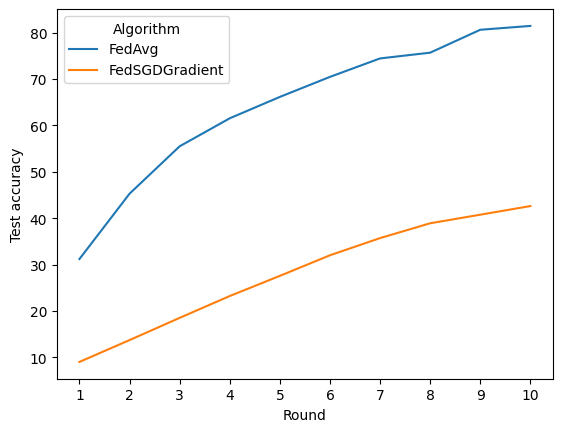

In [ ]:
client_fraction = 0.2
client_subsets_iid = split(100, True, seed)
Question(lr, client_subsets_iid, client_fraction, nr_rounds)

TODO

## Exercise 3 - Batch size & learning rate (4 points)

### Question

_(2 points)_ Complete the following table with the last-round wall time and test accuracy of FedAvg under different batch sizes:

| Algorithm | B   | η    | Wall time | Test accuracy |
| --------- | --- | ---- | --------- | ------------- |
| FedAvg    | 10  | 0.01 |          3.1 |              92.18 |
| FedAvg    | 100 | 0.01 |          1.6 |              81.78 |
| FedAvg    | 500 | 0.01 |          1.7 |              59.63 |

What is the trade-off for larger batch sizes?

*Note:* The exact measured time will differ from run to run, even on the same machine, but the trends should remain the same. Furthermore, the effect of batch size on wall time is less pronounced and, depending on the exact hardware is sometimes minimal when running on CPU instead of GPU.

_(2 points)_ Add the corresponding values for varying learning rates, also for FedSGD, in the table below:

| Algorithm | B   | η     | Wall time | Test accuracy |
| --------- | --- | ----- | --------- | ------------- |
| FedSGD    | ∞   | 0.001 |          1.0 |              7.39 |
| FedAvg    | 100 | 0.001 |          1.9 |              31.72 |
| FedSGD    | ∞   | 0.01  |          1.0 |              27.34 |
| FedAvg    | 100 | 0.01  |          1.6 |              81.78 |
| FedSGD    | ∞   | 1.0   |           |               |
| FedAvg    | 100 | 1.0   |           |               |

Does the learning rate influence the wall time? For accuracy, how does it change the value obtained within the set number of rounds? Can it impact the model's convergence?

### Answer

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.01,10,0.1,20,9.03
1,2,FedSGDGradient,100,0.1,∞,1,0.01,10,0.1,40,13.54
2,3,FedSGDGradient,100,0.1,∞,1,0.01,10,0.1,60,18.39
3,4,FedSGDGradient,100,0.1,∞,1,0.01,10,0.2,80,22.87
4,5,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,100,27.09
5,6,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,120,31.08
6,7,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,140,35.29
7,8,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,160,38.75
8,9,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,180,41.02
9,10,FedSGDGradient,100,0.1,∞,1,0.01,10,0.6,200,43.20


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,10,2,0.01,10,0.3,20,84.04
1,2,FedAvg,100,0.1,10,2,0.01,10,0.5,40,88.90
2,3,FedAvg,100,0.1,10,2,0.01,10,0.8,60,90.37
3,4,FedAvg,100,0.1,10,2,0.01,10,1.0,80,90.76
4,5,FedAvg,100,0.1,10,2,0.01,10,1.3,100,91.86
5,6,FedAvg,100,0.1,10,2,0.01,10,1.6,120,92.77
6,7,FedAvg,100,0.1,10,2,0.01,10,1.8,140,93.23
7,8,FedAvg,100,0.1,10,2,0.01,10,2.1,160,93.59
8,9,FedAvg,100,0.1,10,2,0.01,10,2.3,180,94.16
9,10,FedAvg,100,0.1,10,2,0.01,10,2.6,200,94.49


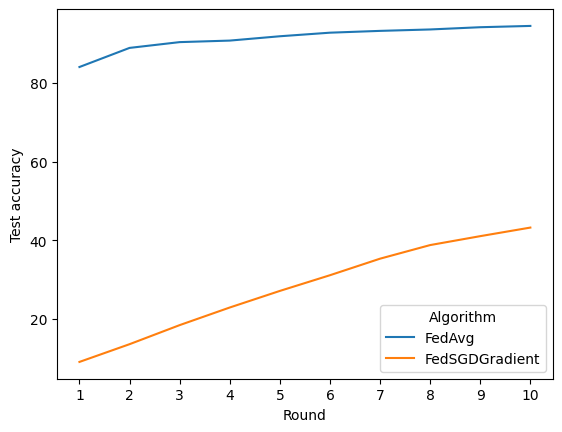

In [ ]:
lr = 0.01
client_fraction = 0.1
client_subsets_iid = split(100, True, seed)
avg_batchsize = 10
Question(lr, client_subsets_iid, client_fraction, nr_rounds, avg_batchsize)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,20,9.03
1,2,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,40,13.54
2,3,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,60,18.39
3,4,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,80,22.87
4,5,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,100,27.09
5,6,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,120,31.08
6,7,FedSGDGradient,100,0.1,∞,1,0.01,10,0.6,140,35.29
7,8,FedSGDGradient,100,0.1,∞,1,0.01,10,0.7,160,38.75
8,9,FedSGDGradient,100,0.1,∞,1,0.01,10,0.7,180,41.02
9,10,FedSGDGradient,100,0.1,∞,1,0.01,10,0.8,200,43.20


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,2,0.01,10,0.1,20,45.07
1,2,FedAvg,100,0.1,100,2,0.01,10,0.2,40,64.41
2,3,FedAvg,100,0.1,100,2,0.01,10,0.3,60,73.25
3,4,FedAvg,100,0.1,100,2,0.01,10,0.4,80,77.54
4,5,FedAvg,100,0.1,100,2,0.01,10,0.5,100,81.88
5,6,FedAvg,100,0.1,100,2,0.01,10,0.6,120,83.63
6,7,FedAvg,100,0.1,100,2,0.01,10,0.7,140,85.60
7,8,FedAvg,100,0.1,100,2,0.01,10,0.8,160,86.85
8,9,FedAvg,100,0.1,100,2,0.01,10,1.0,180,87.68
9,10,FedAvg,100,0.1,100,2,0.01,10,1.1,200,88.17


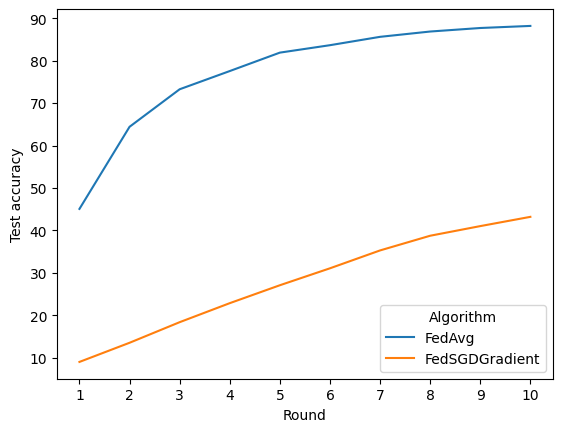

In [ ]:
lr = 0.01
avg_batchsize = 100
Question(lr, client_subsets_iid, client_fraction, nr_rounds, avg_batchsize)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,20,9.03
1,2,FedSGDGradient,100,0.1,∞,1,0.01,10,0.3,40,13.54
2,3,FedSGDGradient,100,0.1,∞,1,0.01,10,0.4,60,18.39
3,4,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,80,22.87
4,5,FedSGDGradient,100,0.1,∞,1,0.01,10,0.5,100,27.09
5,6,FedSGDGradient,100,0.1,∞,1,0.01,10,0.6,120,31.08
6,7,FedSGDGradient,100,0.1,∞,1,0.01,10,0.6,140,35.29
7,8,FedSGDGradient,100,0.1,∞,1,0.01,10,0.7,160,38.75
8,9,FedSGDGradient,100,0.1,∞,1,0.01,10,0.8,180,41.02
9,10,FedSGDGradient,100,0.1,∞,1,0.01,10,0.9,200,43.20


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,500,2,0.01,10,0.1,20,22.77
1,2,FedAvg,100,0.1,500,2,0.01,10,0.2,40,38.22
2,3,FedAvg,100,0.1,500,2,0.01,10,0.3,60,45.20
3,4,FedAvg,100,0.1,500,2,0.01,10,0.4,80,52.50
4,5,FedAvg,100,0.1,500,2,0.01,10,0.5,100,59.65
5,6,FedAvg,100,0.1,500,2,0.01,10,0.6,120,64.50
6,7,FedAvg,100,0.1,500,2,0.01,10,0.7,140,67.67
7,8,FedAvg,100,0.1,500,2,0.01,10,0.8,160,69.58
8,9,FedAvg,100,0.1,500,2,0.01,10,1.0,180,71.21
9,10,FedAvg,100,0.1,500,2,0.01,10,1.1,200,73.14


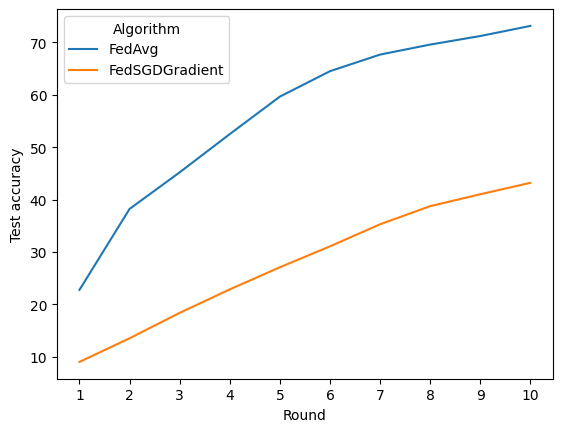

In [ ]:
lr = 0.01
avg_batchsize = 500
Question(lr, client_subsets_iid, client_fraction, nr_rounds, avg_batchsize)

TODO

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.001,10,0.3,20,6.44
1,2,FedSGDGradient,100,0.1,∞,1,0.001,10,0.3,40,6.58
2,3,FedSGDGradient,100,0.1,∞,1,0.001,10,0.4,60,6.76
3,4,FedSGDGradient,100,0.1,∞,1,0.001,10,0.4,80,7.07
4,5,FedSGDGradient,100,0.1,∞,1,0.001,10,0.5,100,7.35
5,6,FedSGDGradient,100,0.1,∞,1,0.001,10,0.5,120,7.62
6,7,FedSGDGradient,100,0.1,∞,1,0.001,10,0.6,140,7.85
7,8,FedSGDGradient,100,0.1,∞,1,0.001,10,0.7,160,8.18
8,9,FedSGDGradient,100,0.1,∞,1,0.001,10,0.7,180,8.46
9,10,FedSGDGradient,100,0.1,∞,1,0.001,10,0.8,200,8.83


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,2,0.001,10,0.1,20,9.83
1,2,FedAvg,100,0.1,100,2,0.001,10,0.2,40,15.46
2,3,FedAvg,100,0.1,100,2,0.001,10,0.3,60,20.83
3,4,FedAvg,100,0.1,100,2,0.001,10,0.4,80,26.57
4,5,FedAvg,100,0.1,100,2,0.001,10,0.5,100,31.12
5,6,FedAvg,100,0.1,100,2,0.001,10,0.6,120,36.36
6,7,FedAvg,100,0.1,100,2,0.001,10,0.7,140,40.04
7,8,FedAvg,100,0.1,100,2,0.001,10,0.8,160,43.15
8,9,FedAvg,100,0.1,100,2,0.001,10,1.0,180,44.64
9,10,FedAvg,100,0.1,100,2,0.001,10,1.1,200,47.18


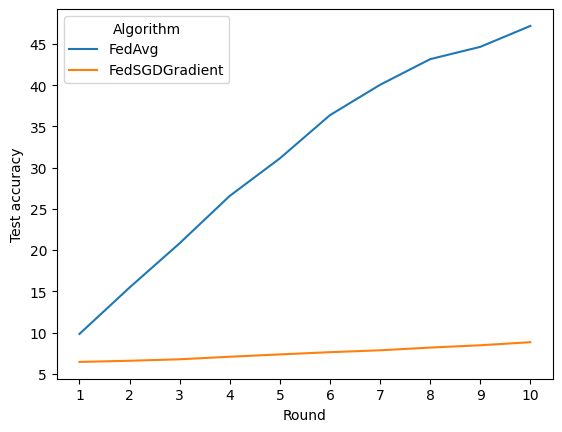

In [ ]:
lr = 0.001
avg_batchsize = 100
Question(lr, client_subsets_iid, client_fraction, nr_rounds, avg_batchsize)

,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,1.0,10,0.3,20,36.30
1,2,FedSGDGradient,100,0.1,∞,1,1.0,10,0.3,40,39.98
2,3,FedSGDGradient,100,0.1,∞,1,1.0,10,0.4,60,9.74
3,4,FedSGDGradient,100,0.1,∞,1,1.0,10,0.4,80,11.45
4,5,FedSGDGradient,100,0.1,∞,1,1.0,10,0.5,100,11.35
5,6,FedSGDGradient,100,0.1,∞,1,1.0,10,0.6,120,10.09
6,7,FedSGDGradient,100,0.1,∞,1,1.0,10,0.6,140,11.35
7,8,FedSGDGradient,100,0.1,∞,1,1.0,10,0.7,160,11.35
8,9,FedSGDGradient,100,0.1,∞,1,1.0,10,0.8,180,11.35
9,10,FedSGDGradient,100,0.1,∞,1,1.0,10,0.8,200,11.35


,Round,Algorithm,N,C,B,E,η,Seed,Wall time,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,2,1.0,10,0.1,20,11.35
1,2,FedAvg,100,0.1,100,2,1.0,10,0.2,40,9.80
2,3,FedAvg,100,0.1,100,2,1.0,10,0.3,60,9.80
3,4,FedAvg,100,0.1,100,2,1.0,10,0.4,80,9.80
4,5,FedAvg,100,0.1,100,2,1.0,10,0.5,100,9.80
5,6,FedAvg,100,0.1,100,2,1.0,10,0.6,120,9.80
6,7,FedAvg,100,0.1,100,2,1.0,10,0.7,140,9.80
7,8,FedAvg,100,0.1,100,2,1.0,10,0.8,160,9.80
8,9,FedAvg,100,0.1,100,2,1.0,10,1.0,180,9.80
9,10,FedAvg,100,0.1,100,2,1.0,10,1.1,200,9.80


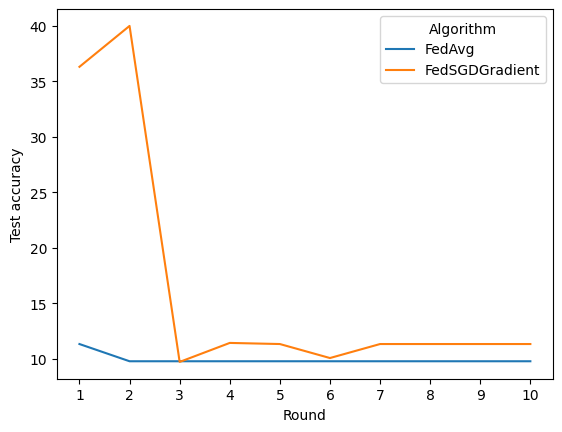

: 

In [ ]:
lr = 1.0
avg_batchsize = 100
Question(lr, client_subsets_iid, client_fraction, nr_rounds, avg_batchsize)

TODO

## Exercise 4 - Local epoch count & (non-)IID data (5 points)

### Question

_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?

_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default). How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?

4 figure

_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from before, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. How does the stability of the new variants compare to the old ones? Why do the changes in parameters have the observed effect?

4 figure

### Answer

In [ ]:
# TODO

TODO

In [ ]:
# TODO

TODO

In [ ]:
# TODO

TODO